## Analysis of NMM treatment Microarray data using PUMA

In [1]:
library(ggplot2)
setwd('/home/matthew/Documents/analysis_notebooks/tair10_nmm_6h_24h/data')

In [2]:
library(oligo, verbose = FALSE)
library(puma, verbose = FALSE)

samples = paste(rep(c('DMSO', 'DMSO', rep('NMM', 3)), 2),
                rep(c('6h', '24h'), each=5),
                sep='_')
samples_num = paste(samples, c(1:2,1:3), sep='_')

cel <- read.celfiles(paste('./cel/',
                           list.celfiles('./cel'),
                           sep=''),
                     sampleNames=samples_num)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit

Loading required package: oligoClasses
No methods found in "RSQLite" for requests: dbGetQuery
Welcome to oligoClasses version 1.34.0
Loading required package: Bio

Reading in : ./cel/01_6hDMSO1_(AraGene-1_0-st).CEL
Reading in : ./cel/02_6hDMSO2_(AraGene-1_0-st).CEL
Reading in : ./cel/02_6hNMM1_(AraGene-1_0-st).CEL
Reading in : ./cel/04_6hNMM2_(AraGene-1_0-st).CEL
Reading in : ./cel/05_6hNMM3_(AraGene-1_0-st).CEL
Reading in : ./cel/06_24hDMSO1_(AraGene-1_0-st).CEL
Reading in : ./cel/07_24hDMSO2_(AraGene-1_0-st).CEL
Reading in : ./cel/08_24hNMM1_(AraGene-1_0-st).CEL
Reading in : ./cel/09_24hNMM2_(AraGene-1_0-st).CEL
Reading in : ./cel/10_24hNMM3_(AraGene-1_0-st).CEL


In [4]:
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.4 LTS

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] pd.aragene.1.0.st_3.12.0 DBI_0.8                  RSQLite_2.0             
 [4] puma_3.14.0              mclust_5.4               oligo_1.36.1            
 [7] Biostrings_2.40.2        XVector_0.12.1           IRanges_2.6.1           
[10] S4Vectors_0.10.3         Biobase_2.32.0           oligoClasses_1.34.0     
[13] BiocGenerics_0.18.0      ggplot2_2.2.1           

loaded via

In [4]:
f <- factor(samples)
design_matrix <- model.matrix(~0 + f)
rownames(design_matrix) <- samples_num
colnames(design_matrix) <- levels(f)
design_matrix

,DMSO_24h,DMSO_6h,NMM_24h,NMM_6h
DMSO_6h_1,0,1,0,0
DMSO_6h_2,0,1,0,0
NMM_6h_1,0,0,0,1
NMM_6h_2,0,0,0,1
NMM_6h_3,0,0,0,1
DMSO_24h_1,1,0,0,0
DMSO_24h_2,1,0,0,0
NMM_24h_1,0,0,1,0
NMM_24h_2,0,0,1,0
NMM_24h_3,0,0,1,0


Contrast 6 and 24 hour treated against mock, also 24 hour against 6 hour to look at change in gene expression with time

In [5]:
normalised <- PMmmgmos(cel, gsnorm='median')

Model optimising ..........................................................................................................................................................
Expression values calculating ...........................................................................
Done.


In [6]:
combined <- pumaCombImproved(normalised, design.matrix = design_matrix)

pumaComb expected completion time is 63 minutes 
.......20%.......40%.......60%.......80%......100%
..................................................


In [15]:
pplrs <- pumaDE(combined)
save(normalised, combined, pplrs, file='puma_objects.rdata', compress=TRUE)

In [6]:
#run from here
library(oligo)
library(puma)
load('puma_objects.rdata')

In [7]:
?pumaDE

Warning message:
: Removed 2013 rows containing non-finite values (stat_ydensity).Warning message:
: Removed 2013 rows containing non-finite values (stat_boxplot).

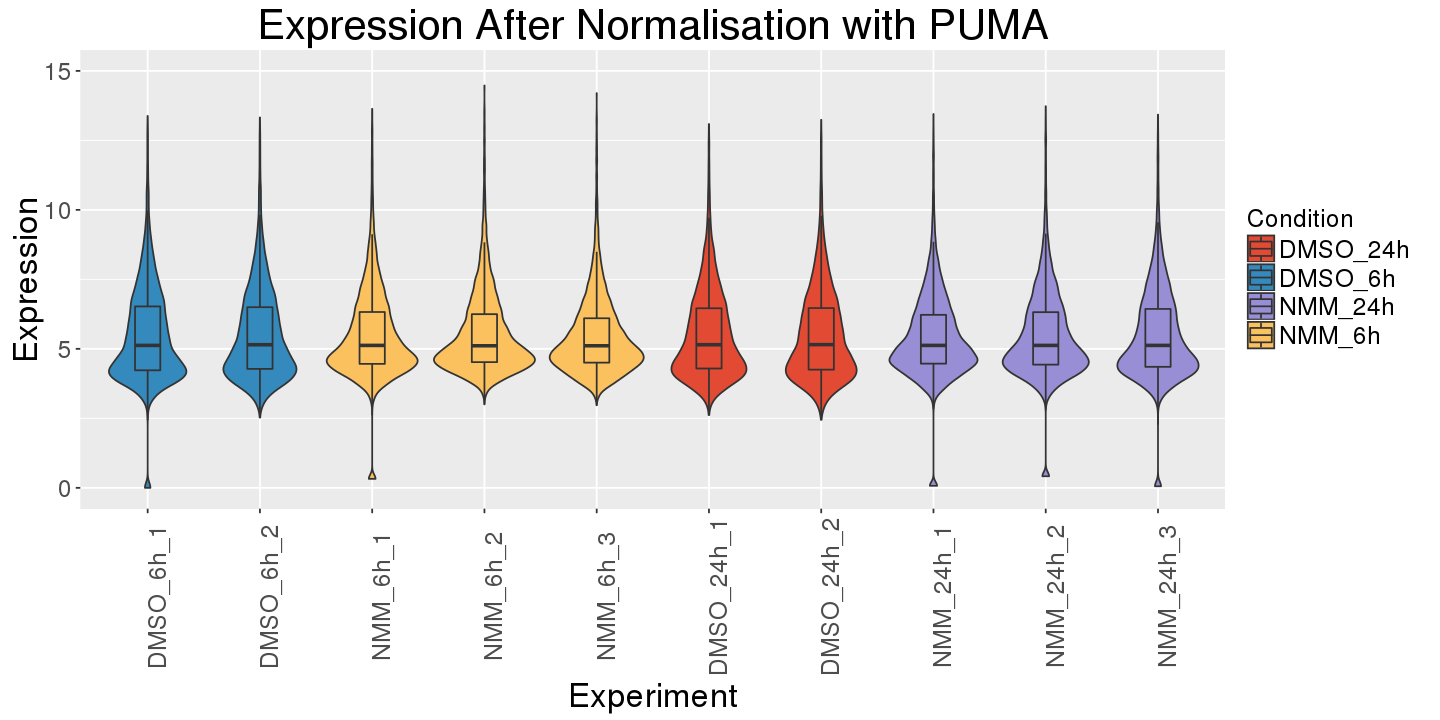

In [10]:
options(repr.plot.width=12, repr.plot.height=6)
e <- as.data.frame(exprs(normalised))
e <- reshape2::melt(e, id.vars = NULL)
e['Condition'] <- substr(e$variable, 0, nchar(as.character(e$variable)) - 2)
colnames(e) <- c('Experiment', 'Expression', 'Condition')
ggplot(e, aes(x=Experiment, y=Expression)) +
  geom_violin(aes(fill=Condition),
              scale = 'area', trim=TRUE) +
  ylim(0, 15) + labs(title='Expression After Normalisation with PUMA') +
  geom_boxplot(aes(fill=Condition),
               width=0.3,
               outlier.shape=NA) +
  theme(axis.text.x = element_text(angle=90),
        axis.text = element_text(size=15),
        plot.title = element_text(size=25),
        axis.title = element_text(size=20),
        legend.text = element_text(size=15),
        legend.title = element_text(size=15)) +
  color_palette

Warning message:
: Removed 867 rows containing non-finite values (stat_ydensity).Warning message:
: Removed 867 rows containing non-finite values (stat_boxplot).

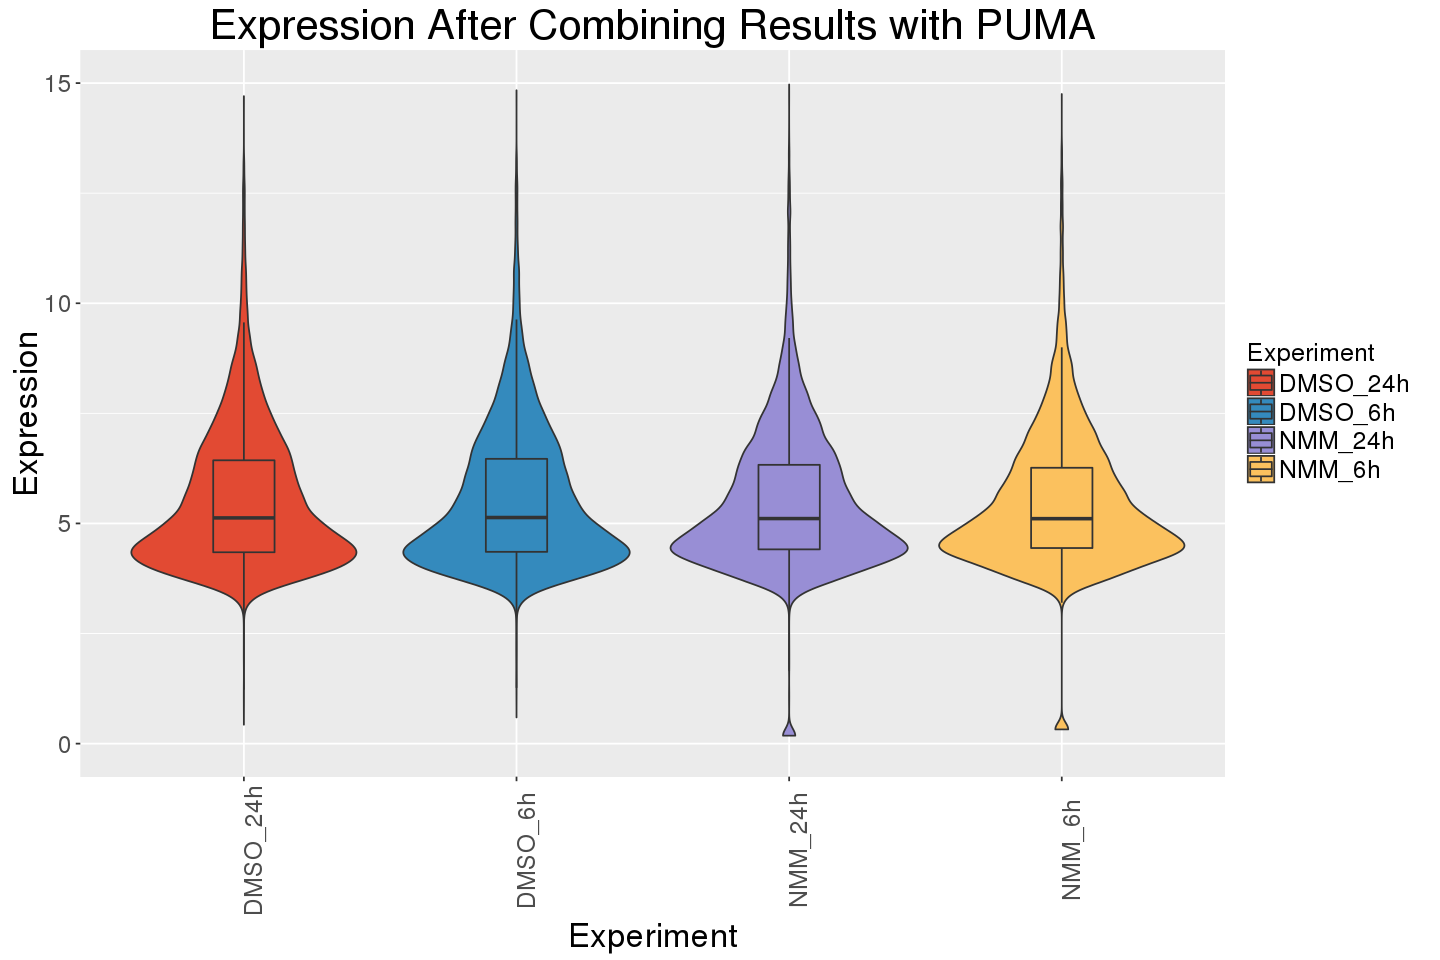

In [12]:
options(repr.plot.width=12, repr.plot.height=8)
e <- as.data.frame(exprs(combined))
e <- reshape2::melt(e, id.vars = NULL)
colnames(e) <- c('Experiment', 'Expression')
ggplot(e, aes(x=Experiment, y=Expression)) +
  geom_violin(aes(fill=Experiment),
              scale = 'area', trim=TRUE) +
  geom_boxplot(aes(fill=Experiment),
               width=0.3,
               outlier.shape=NA) +
  ylim(0, 15) + labs(title='Expression After Combining Results with PUMA') +
  theme(axis.text.x = element_text(angle=90),
        axis.text = element_text(size=15),
        plot.title = element_text(size=25),
        axis.title = element_text(size=20),
        legend.text = element_text(size=15),
        legend.title = element_text(size=15)) +
  color_palette

In [17]:
head(statistic(pplrs))

,NMM_6h - DMSO_6h,NMM_24h - DMSO_24h,NMM_24h - NMM_6h
13320001,0.45,0.50,0.49
13320003,0.20,0.90,0.77
13320005,0.42,0.51,0.51
13320007,0.44,0.46,0.46
13320009,0.41,0.44,0.16
13320011,3.4e-11,9.6e-01,2.1e-16
